# Multiple output from LSTM Model

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from keras.optimizers import RMSprop # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import seaborn as sns

In [171]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

### Prossessing functions

In [172]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

### LSTM functions

In [173]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_pred': train_pred,
               'train_true': y_train,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

### Random Forest functions

In [174]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

### Overlapping campaigns

* Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi, Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi

* Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel, Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel

* Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2, Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode

* Ping_UNIDATA_4G5G_TIM_Driving_Luca, Interactivity_gaming_4G5G_TIM_Driving_Luca, Capacity_Ookla_4G5G_Tim_Driving_Luca

### Parameters

In [175]:
tf.random.set_seed(4567)

# LSTM
n_steps_in = 5
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
min_leaf_size = 5

In [176]:
overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi', 
             'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
             'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
             'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
             'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
             'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
             'Capacity_Ookla_4G5G_Tim_Driving_Luca']

In [177]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[0]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[1]])

## 2 Steps prediction

In [178]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [194]:
n_steps_in = 8
n_steps_out = 2

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR -> RSRP",0.00245,0.00211,0.59,0.83
1,"RSRP, RSRQ -> RSRP",0.00305,0.00334,0.98,1.24
2,"RSRP, SINR, RSRQ -> RSRP",0.00264,0.00260,0.80,1.01
3,"RSRP, SSS_RSRP -> RSRP",0.00238,0.00265,0.58,0.91
4,All -> RSRP,0.00253,0.00291,0.80,1.14
5,"RSRP, SINR -> SINR",0.00226,0.00471,0.65,1.22
6,"SINR, RSRQ -> SINR",0.00218,0.00222,0.61,1.02
7,"RSRP, SINR, RSRQ -> SINR",0.00212,0.00319,0.68,1.12
8,"SINR, SSS_SINR -> SINR",0.00213,0.00248,0.58,0.97
9,All -> SINR,0.00221,0.00301,0.96,1.31


In [180]:
selected_rsrp, selected_sinr, selected_rsrq = 'RSRP, SINR, RSRQ -> RSRP', 'RSRP, SINR, RSRQ -> SINR', 'RSRP, SINR, RSRQ -> RSRQ'
selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ'

rsrp_lstm, sinr_lstm, rsrq_lstm = lstm_results[selected_rsrp], lstm_results[selected_sinr], lstm_results[selected_rsrq]
sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = lstm_results[selected_sss_rsrp], lstm_results[selected_sss_sinr], lstm_results[selected_sss_rsrq]

rsrp_lstm_mae = rsrp_lstm['list_mae']
rsrp_first_step, rsrp_second_step = rsrp_lstm_mae[:, 0], rsrp_lstm_mae[:, 1]

sinr_lstm_mae = sinr_lstm['list_mae']
sinr_first_step, sinr_second_step = sinr_lstm_mae[:, 0], sinr_lstm_mae[:, 1]

rsrq_lstm_mae = rsrq_lstm['list_mae']
rsrq_first_step, rsrq_second_step = rsrq_lstm_mae[:, 0], rsrq_lstm_mae[:, 1]

sss_rsrp_lstm_mae = sss_rsrp_lstm['list_mae']
sss_rsrp_first_step, sss_rsrp_second_step = sss_rsrp_lstm_mae[:, 0], sss_rsrp_lstm_mae[:, 1]

sss_sinr_lstm_mae = sss_sinr_lstm['list_mae']
sss_sinr_first_step, sss_sinr_second_step = sss_sinr_lstm_mae[:, 0], sss_sinr_lstm_mae[:, 1]

sss_rsrq_lstm_mae = sss_rsrq_lstm['list_mae']
sss_rsrq_first_step, sss_rsrq_second_step = sss_rsrq_lstm_mae[:, 0], sss_rsrq_lstm_mae[:, 1]

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
sns.boxplot(data=[rsrp_first_step, rsrp_second_step], color=rsrp_colors[2], ax=axes[0, 0])
axes[0, 0].set_title('Mean absolute errors of RSRP')

sns.boxplot(data=[sinr_first_step, sinr_second_step], color=sinr_colors[2], ax=axes[0, 1])
axes[0, 1].set_title('Mean absolute errors of SINR')

sns.boxplot(data=[rsrq_first_step, rsrq_second_step], color=rsrq_colors[2], ax=axes[0, 2])
axes[0, 2].set_title('Mean absolute errors of RSRQ')

sns.boxplot(data=[sss_rsrp_first_step, sss_rsrp_second_step], color=rsrp_colors[2], ax=axes[1, 0])
axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

sns.boxplot(data=[sss_sinr_first_step, sss_sinr_second_step], color=sinr_colors[2], ax=axes[1, 1])
axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

sns.boxplot(data=[sss_rsrq_first_step, sss_rsrq_second_step], color=rsrq_colors[2], ax=axes[1, 2])
axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

for ax in axes.flat:
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Timestep')
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'])

plt.suptitle(f'{n_steps_out} Timesteps Ahead', fontsize=16, fontweight='semibold')

plt.show()

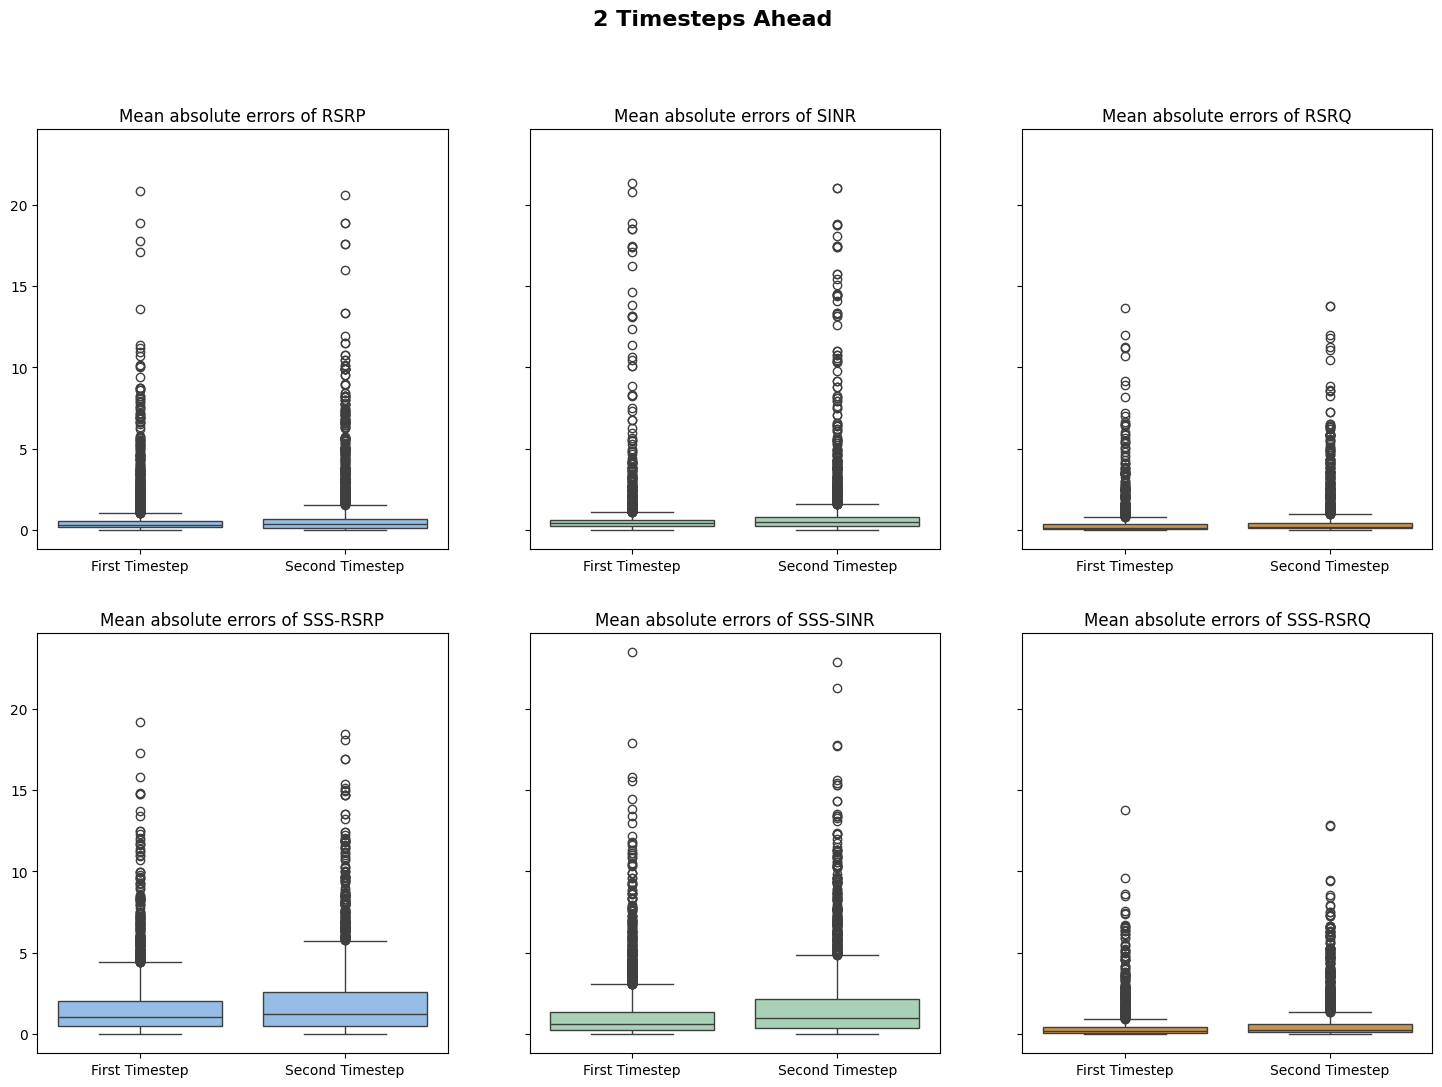

In [181]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
sns.boxplot(data=[rsrp_first_step, rsrp_second_step], color=rsrp_colors[2], ax=axes[0, 0])
axes[0, 0].set_title('Mean absolute errors of RSRP')

sns.boxplot(data=[sinr_first_step, sinr_second_step], color=sinr_colors[2], ax=axes[0, 1])
axes[0, 1].set_title('Mean absolute errors of SINR')

sns.boxplot(data=[rsrq_first_step, rsrq_second_step], color=rsrq_colors[2], ax=axes[0, 2])
axes[0, 2].set_title('Mean absolute errors of RSRQ')

sns.boxplot(data=[sss_rsrp_first_step, sss_rsrp_second_step], color=rsrp_colors[2], ax=axes[1, 0])
axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

sns.boxplot(data=[sss_sinr_first_step, sss_sinr_second_step], color=sinr_colors[2], ax=axes[1, 1])
axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

sns.boxplot(data=[sss_rsrq_first_step, sss_rsrq_second_step], color=rsrq_colors[2], ax=axes[1, 2])
axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

for ax in axes.flat:
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['First Timestep', 'Second Timestep'])

plt.suptitle(f'{n_steps_out} Timesteps Ahead', fontsize=16, fontweight='semibold')

plt.show()

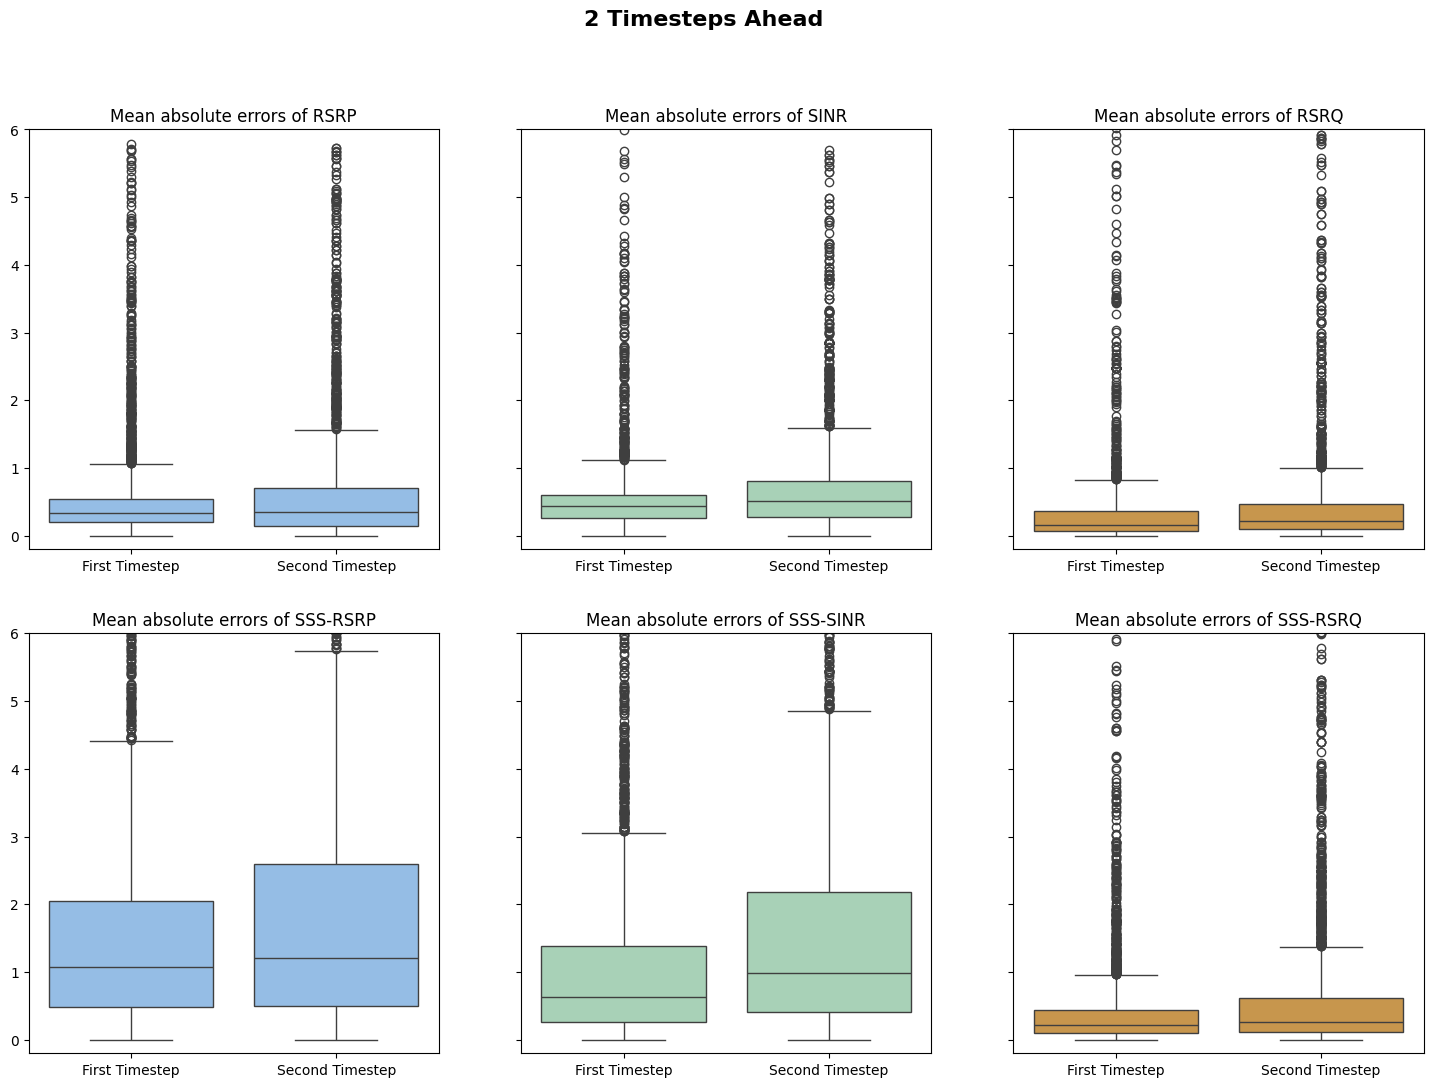

In [182]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
sns.boxplot(data=[rsrp_first_step, rsrp_second_step], color=rsrp_colors[2], ax=axes[0, 0])
axes[0, 0].set_title('Mean absolute errors of RSRP')

sns.boxplot(data=[sinr_first_step, sinr_second_step], color=sinr_colors[2], ax=axes[0, 1])
axes[0, 1].set_title('Mean absolute errors of SINR')

sns.boxplot(data=[rsrq_first_step, rsrq_second_step], color=rsrq_colors[2], ax=axes[0, 2])
axes[0, 2].set_title('Mean absolute errors of RSRQ')

sns.boxplot(data=[sss_rsrp_first_step, sss_rsrp_second_step], color=rsrp_colors[2], ax=axes[1, 0])
axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

sns.boxplot(data=[sss_sinr_first_step, sss_sinr_second_step], color=sinr_colors[2], ax=axes[1, 1])
axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

sns.boxplot(data=[sss_rsrq_first_step, sss_rsrq_second_step], color=rsrq_colors[2], ax=axes[1, 2])
axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

for ax in axes.flat:
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['First Timestep', 'Second Timestep'])

axes[0, 0].set_ylim(-0.2, 6)
plt.suptitle(f'{n_steps_out} Timesteps Ahead', fontsize=16, fontweight='semibold')

plt.show()

## 3 Steps Prediction

In [183]:
n_steps_in = 10
n_steps_out = 3

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR -> RSRP",0.00317,0.00297,0.85,1.13
1,"RSRP, RSRQ -> RSRP",0.00319,0.00299,0.92,1.17
2,"RSRP, SINR, RSRQ -> RSRP",0.00306,0.00306,0.75,1.06
3,"RSRP, SSS_RSRP -> RSRP",0.00316,0.00804,0.79,1.44
4,All -> RSRP,0.00306,0.00394,0.97,1.28
5,"RSRP, SINR -> SINR",0.00270,0.00532,0.83,1.47
6,"SINR, RSRQ -> SINR",0.00279,0.00270,0.76,1.29
7,"RSRP, SINR, RSRQ -> SINR",0.00274,0.00369,0.83,1.42
8,"SINR, SSS_SINR -> SINR",0.00274,0.00208,0.84,1.26
9,All -> SINR,0.00269,0.00178,0.95,1.22


In [184]:
selected_rsrp, selected_sinr, selected_rsrq = 'RSRP, SINR, RSRQ -> RSRP', 'RSRP, SINR, RSRQ -> SINR', 'RSRP, SINR, RSRQ -> RSRQ'
selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ'

rsrp_lstm, sinr_lstm, rsrq_lstm = lstm_results[selected_rsrp], lstm_results[selected_sinr], lstm_results[selected_rsrq]
sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = lstm_results[selected_sss_rsrp], lstm_results[selected_sss_sinr], lstm_results[selected_sss_rsrq]

rsrp_lstm_mae = rsrp_lstm['list_mae']
rsrp_first_step, rsrp_second_step, rsrp_third_step = rsrp_lstm_mae[:, 0], rsrp_lstm_mae[:, 1], rsrp_lstm_mae[:, 2]

sinr_lstm_mae = sinr_lstm['list_mae']
sinr_first_step, sinr_second_step, sinr_third_step = sinr_lstm_mae[:, 0], sinr_lstm_mae[:, 1], sinr_lstm_mae[:, 2]

rsrq_lstm_mae = rsrq_lstm['list_mae']
rsrq_first_step, rsrq_second_step, rsrq_third_step = rsrq_lstm_mae[:, 0], rsrq_lstm_mae[:, 1], rsrq_lstm_mae[:, 2]

sss_rsrp_lstm_mae = sss_rsrp_lstm['list_mae']
sss_rsrp_first_step, sss_rsrp_second_step, sss_rsrp_third_step = sss_rsrp_lstm_mae[:, 0], sss_rsrp_lstm_mae[:, 1], sss_rsrp_lstm_mae[:, 2]

sss_sinr_lstm_mae = sss_sinr_lstm['list_mae']
sss_sinr_first_step, sss_sinr_second_step, sss_sinr_third_step = sss_sinr_lstm_mae[:, 0], sss_sinr_lstm_mae[:, 1], sss_sinr_lstm_mae[:, 2]

sss_rsrq_lstm_mae = sss_rsrq_lstm['list_mae']
sss_rsrq_first_step, sss_rsrq_second_step, sss_rsrq_third_step = sss_rsrq_lstm_mae[:, 0], sss_rsrq_lstm_mae[:, 1], sss_rsrq_lstm_mae[:, 2]

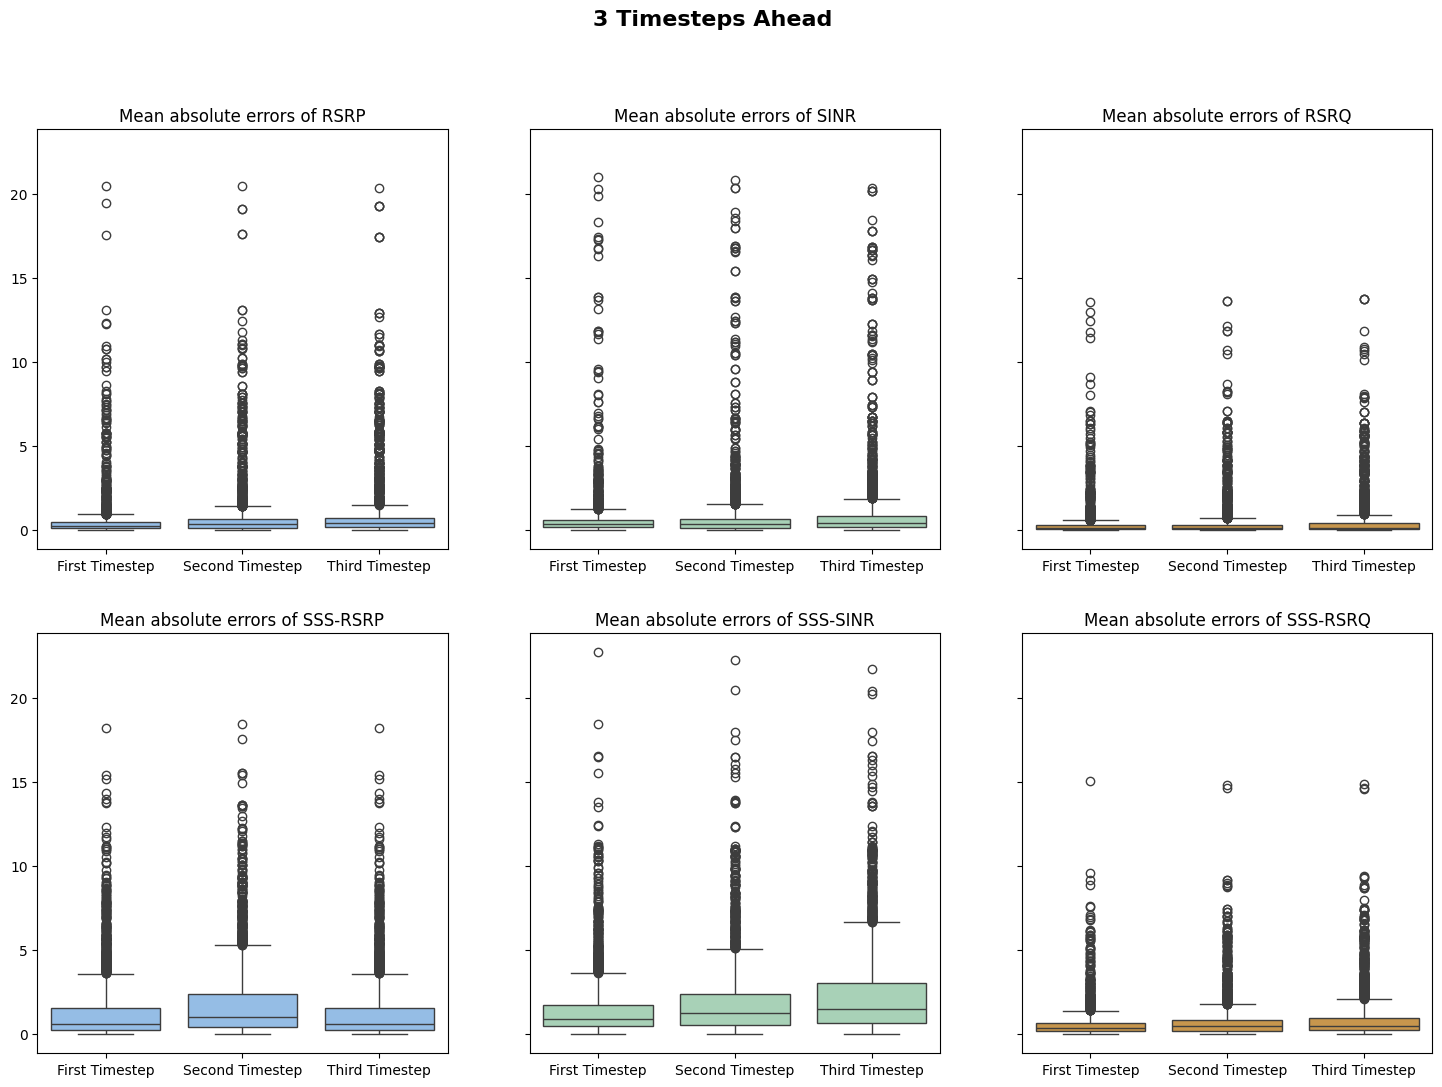

In [185]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
sns.boxplot(data=[rsrp_first_step, rsrp_second_step, rsrp_third_step], color=rsrp_colors[2], ax=axes[0, 0])
axes[0, 0].set_title('Mean absolute errors of RSRP')

sns.boxplot(data=[sinr_first_step, sinr_second_step, sinr_third_step], color=sinr_colors[2], ax=axes[0, 1])
axes[0, 1].set_title('Mean absolute errors of SINR')

sns.boxplot(data=[rsrq_first_step, rsrq_second_step, rsrq_third_step], color=rsrq_colors[2], ax=axes[0, 2])
axes[0, 2].set_title('Mean absolute errors of RSRQ')

sns.boxplot(data=[sss_rsrp_first_step, sss_rsrp_second_step, sss_rsrp_first_step], color=rsrp_colors[2], ax=axes[1, 0])
axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

sns.boxplot(data=[sss_sinr_first_step, sss_sinr_second_step, sss_sinr_third_step], color=sinr_colors[2], ax=axes[1, 1])
axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

sns.boxplot(data=[sss_rsrq_first_step, sss_rsrq_second_step, sss_rsrq_third_step], color=rsrq_colors[2], ax=axes[1, 2])
axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

for ax in axes.flat:
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['First Timestep', 'Second Timestep', 'Third Timestep'])
    
plt.suptitle(f'{n_steps_out} Timesteps Ahead', fontsize=16, fontweight='semibold')

plt.show()

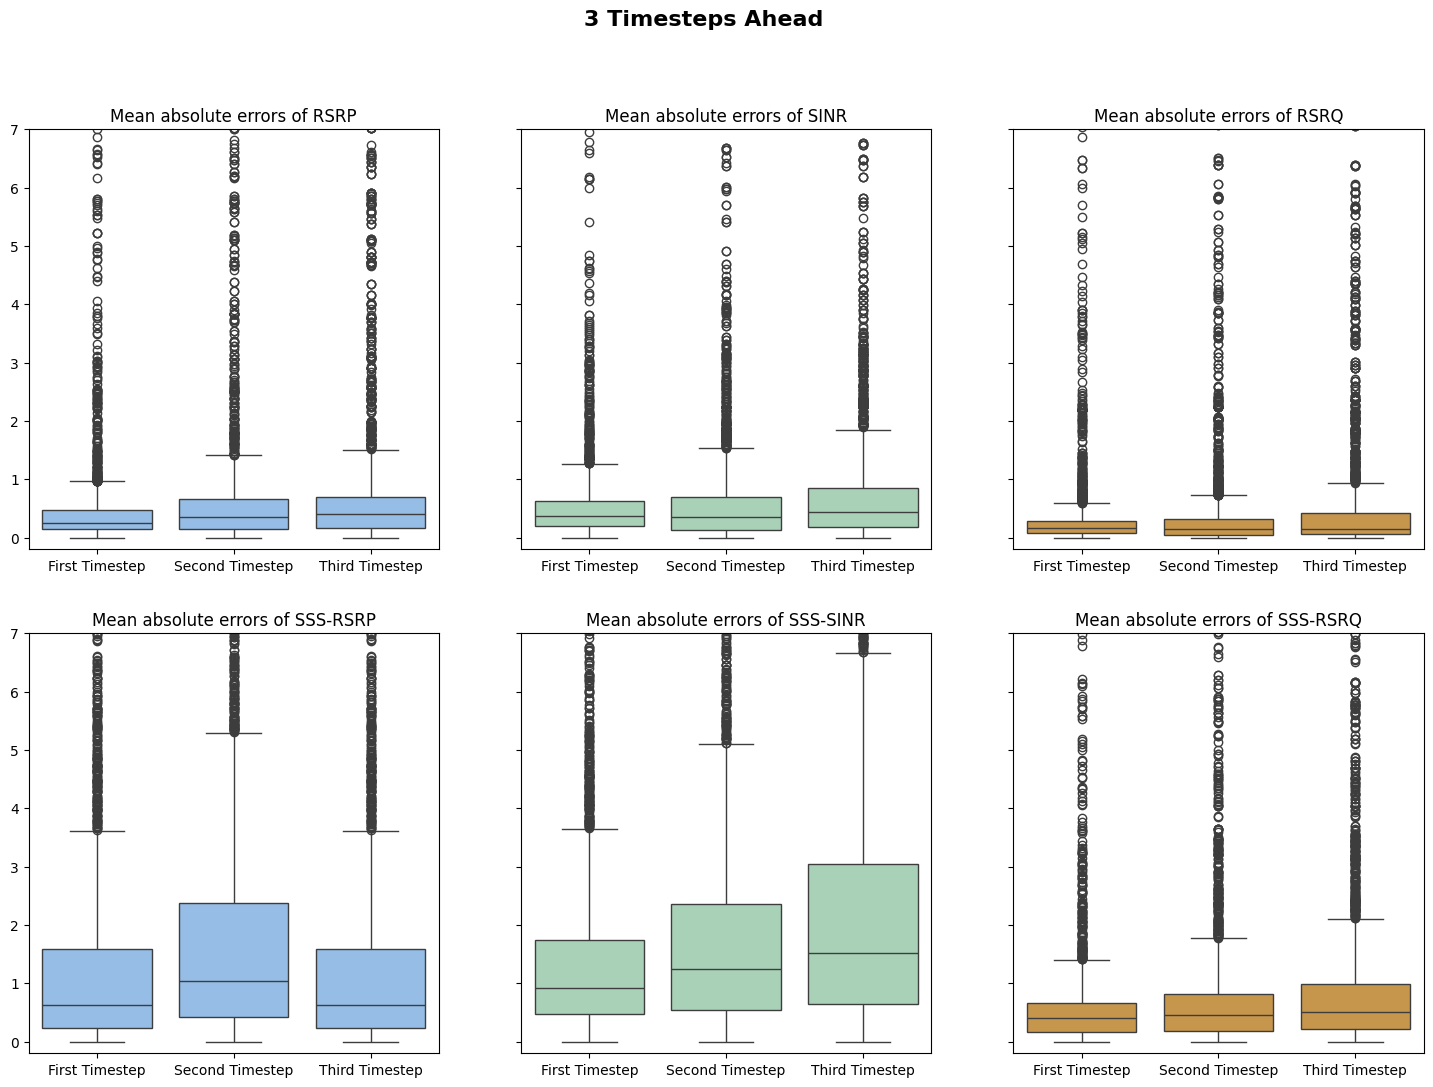

In [186]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
sns.boxplot(data=[rsrp_first_step, rsrp_second_step, rsrp_third_step], color=rsrp_colors[2], ax=axes[0, 0])
axes[0, 0].set_title('Mean absolute errors of RSRP')

sns.boxplot(data=[sinr_first_step, sinr_second_step, sinr_third_step], color=sinr_colors[2], ax=axes[0, 1])
axes[0, 1].set_title('Mean absolute errors of SINR')

sns.boxplot(data=[rsrq_first_step, rsrq_second_step, rsrq_third_step], color=rsrq_colors[2], ax=axes[0, 2])
axes[0, 2].set_title('Mean absolute errors of RSRQ')

sns.boxplot(data=[sss_rsrp_first_step, sss_rsrp_second_step, sss_rsrp_first_step], color=rsrp_colors[2], ax=axes[1, 0])
axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

sns.boxplot(data=[sss_sinr_first_step, sss_sinr_second_step, sss_sinr_third_step], color=sinr_colors[2], ax=axes[1, 1])
axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

sns.boxplot(data=[sss_rsrq_first_step, sss_rsrq_second_step, sss_rsrq_third_step], color=rsrq_colors[2], ax=axes[1, 2])
axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

for ax in axes.flat:
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['First Timestep', 'Second Timestep', 'Third Timestep'])

axes[0, 0].set_ylim(-0.2, 7)
plt.suptitle(f'{n_steps_out} Timesteps Ahead', fontsize=16, fontweight='semibold')

plt.show()

## 5 Steps Prediction

In [187]:
n_steps_in = 15
n_steps_out = 5

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR -> RSRP",0.00438,0.00947,1.08,1.64
1,"RSRP, RSRQ -> RSRP",0.00434,0.00459,1.10,1.50
2,"RSRP, SINR, RSRQ -> RSRP",0.00438,0.00660,1.04,1.58
3,"RSRP, SSS_RSRP -> RSRP",0.00450,0.00769,1.08,1.69
4,All -> RSRP,0.00408,0.00846,1.33,1.80
5,"RSRP, SINR -> SINR",0.00343,0.00649,1.08,1.73
6,"SINR, RSRQ -> SINR",0.00337,0.00386,1.02,1.59
7,"RSRP, SINR, RSRQ -> SINR",0.00349,0.00539,1.29,1.83
8,"SINR, SSS_SINR -> SINR",0.00401,0.01139,1.03,1.92
9,All -> SINR,0.00340,0.00678,1.29,1.89


In [188]:
selected_rsrp, selected_sinr, selected_rsrq = 'RSRP, SINR, RSRQ -> RSRP', 'RSRP, SINR, RSRQ -> SINR', 'RSRP, SINR, RSRQ -> RSRQ'
selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ'

rsrp_lstm, sinr_lstm, rsrq_lstm = lstm_results[selected_rsrp], lstm_results[selected_sinr], lstm_results[selected_rsrq]
sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = lstm_results[selected_sss_rsrp], lstm_results[selected_sss_sinr], lstm_results[selected_sss_rsrq]

rsrp_lstm_mae = rsrp_lstm['list_mae']
rsrp_first_step, rsrp_second_step, rsrp_third_step, rsrp_fourth_step, rsrp_fifth_step = rsrp_lstm_mae[:, 0], rsrp_lstm_mae[:, 1], rsrp_lstm_mae[:, 2], rsrp_lstm_mae[:, 3], rsrp_lstm_mae[:, 4]

sinr_lstm_mae = sinr_lstm['list_mae']
sinr_first_step, sinr_second_step, sinr_third_step, sinr_fourth_step, sinr_fifth_step = sinr_lstm_mae[:, 0], sinr_lstm_mae[:, 1], sinr_lstm_mae[:, 2], sinr_lstm_mae[:, 3], sinr_lstm_mae[:, 4]

rsrq_lstm_mae = rsrq_lstm['list_mae']
rsrq_first_step, rsrq_second_step, rsrq_third_step, rsrq_fourth_step, rsrq_fifth_step = rsrq_lstm_mae[:, 0], rsrq_lstm_mae[:, 1], rsrq_lstm_mae[:, 2], rsrq_lstm_mae[:, 3], rsrq_lstm_mae[:, 4]

sss_rsrp_lstm_mae = sss_rsrp_lstm['list_mae']
sss_rsrp_first_step, sss_rsrp_second_step, sss_rsrp_third_step, sss_rsrp_fourth_step, sss_rsrp_fifth_step = sss_rsrp_lstm_mae[:, 0], sss_rsrp_lstm_mae[:, 1], sss_rsrp_lstm_mae[:, 2], sss_rsrp_lstm_mae[:, 3], sss_rsrp_lstm_mae[:, 4]

sss_sinr_lstm_mae = sss_sinr_lstm['list_mae']
sss_sinr_first_step, sss_sinr_second_step, sss_sinr_third_step, sss_sinr_fourth_step, sss_sinr_fifth_step = sss_sinr_lstm_mae[:, 0], sss_sinr_lstm_mae[:, 1], sss_sinr_lstm_mae[:, 2], sss_sinr_lstm_mae[:, 3], sss_sinr_lstm_mae[:, 4]

sss_rsrq_lstm_mae = sss_rsrq_lstm['list_mae']
sss_rsrq_first_step, sss_rsrq_second_step, sss_rsrq_third_step, sss_rsrq_fourth_step, sss_rsrq_fifth_step = sss_rsrq_lstm_mae[:, 0], sss_rsrq_lstm_mae[:, 1], sss_rsrq_lstm_mae[:, 2], sss_rsrq_lstm_mae[:, 3], sss_rsrq_lstm_mae[:, 4]

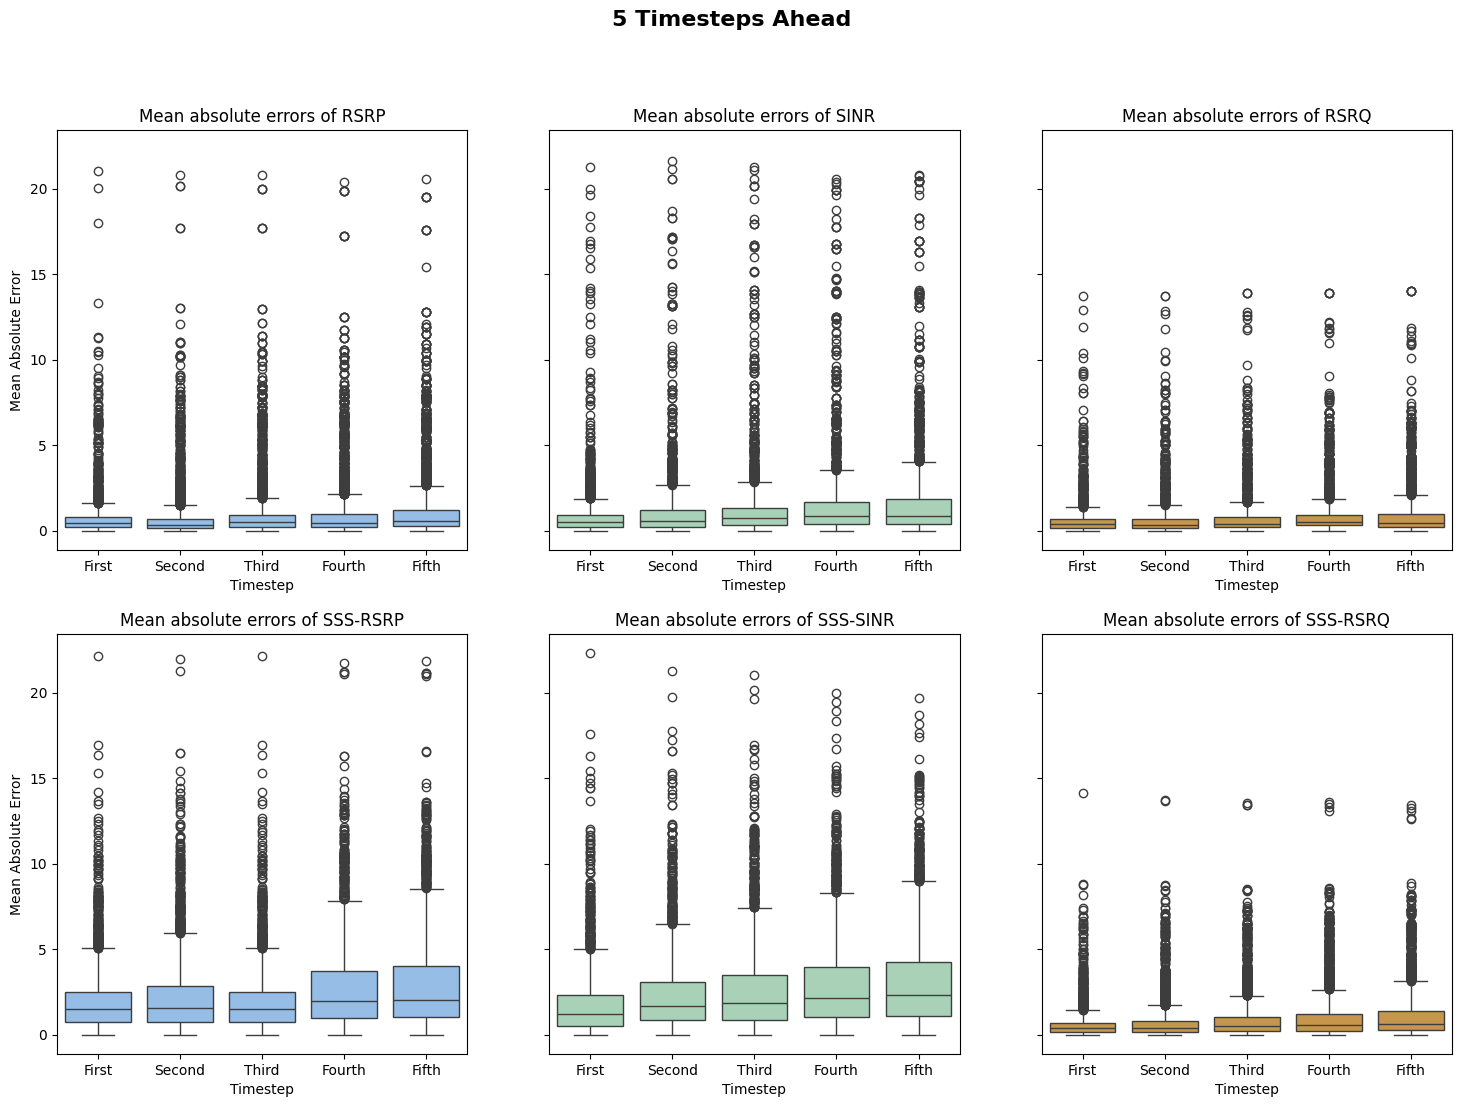

In [189]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
sns.boxplot(data=[rsrp_first_step, rsrp_second_step, rsrp_third_step, rsrp_fourth_step, rsrp_fifth_step], color=rsrp_colors[2], ax=axes[0, 0])
axes[0, 0].set_title('Mean absolute errors of RSRP')

sns.boxplot(data=[sinr_first_step, sinr_second_step, sinr_third_step, sinr_fourth_step, sinr_fifth_step], color=sinr_colors[2], ax=axes[0, 1])
axes[0, 1].set_title('Mean absolute errors of SINR')

sns.boxplot(data=[rsrq_first_step, rsrq_second_step, rsrq_third_step, rsrq_fourth_step, rsrq_fifth_step], color=rsrq_colors[2], ax=axes[0, 2])
axes[0, 2].set_title('Mean absolute errors of RSRQ')

sns.boxplot(data=[sss_rsrp_first_step, sss_rsrp_second_step, sss_rsrp_first_step, sss_rsrp_fourth_step, sss_rsrp_fifth_step], color=rsrp_colors[2], ax=axes[1, 0])
axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

sns.boxplot(data=[sss_sinr_first_step, sss_sinr_second_step, sss_sinr_third_step, sss_sinr_fourth_step, sss_sinr_fifth_step], color=sinr_colors[2], ax=axes[1, 1])
axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

sns.boxplot(data=[sss_rsrq_first_step, sss_rsrq_second_step, sss_rsrq_third_step, sss_rsrq_fourth_step, sss_rsrq_fifth_step], color=rsrq_colors[2], ax=axes[1, 2])
axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

for ax in axes.flat:
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Timestep')
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['First', 'Second', 'Third', 'Fourth', 'Fifth'])
    
plt.suptitle(f'{n_steps_out} Timesteps Ahead', fontsize=16, fontweight='semibold')

plt.show()

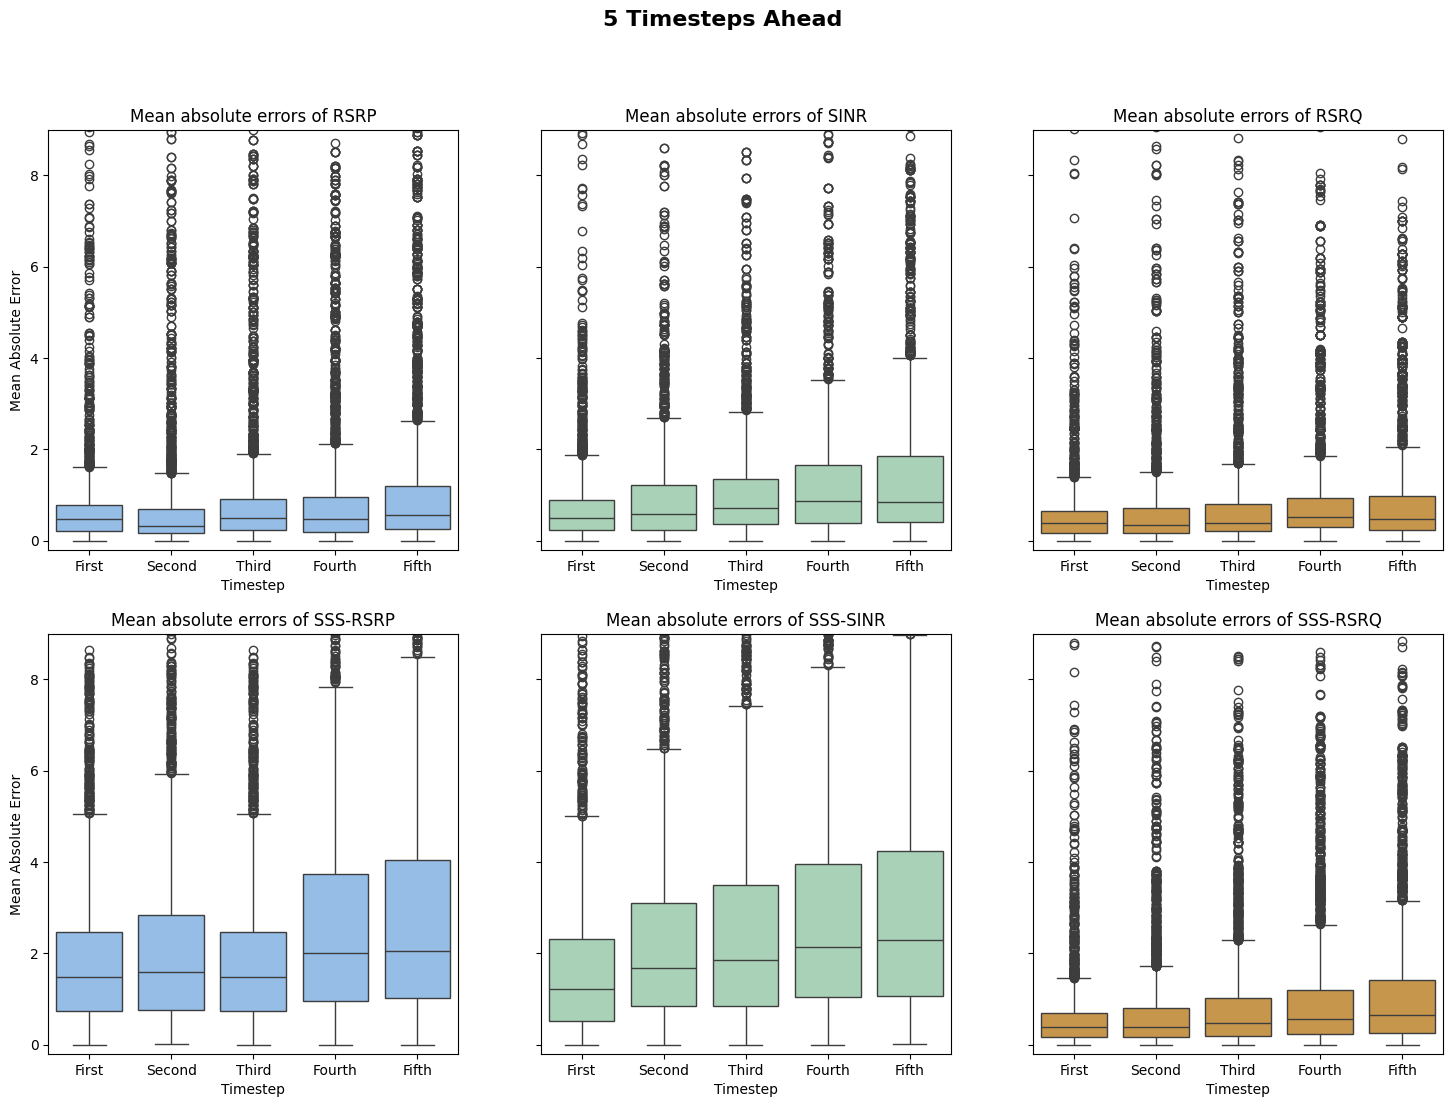

In [190]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
sns.boxplot(data=[rsrp_first_step, rsrp_second_step, rsrp_third_step, rsrp_fourth_step, rsrp_fifth_step], color=rsrp_colors[2], ax=axes[0, 0])
axes[0, 0].set_title('Mean absolute errors of RSRP')

sns.boxplot(data=[sinr_first_step, sinr_second_step, sinr_third_step, sinr_fourth_step, sinr_fifth_step], color=sinr_colors[2], ax=axes[0, 1])
axes[0, 1].set_title('Mean absolute errors of SINR')

sns.boxplot(data=[rsrq_first_step, rsrq_second_step, rsrq_third_step, rsrq_fourth_step, rsrq_fifth_step], color=rsrq_colors[2], ax=axes[0, 2])
axes[0, 2].set_title('Mean absolute errors of RSRQ')

sns.boxplot(data=[sss_rsrp_first_step, sss_rsrp_second_step, sss_rsrp_first_step, sss_rsrp_fourth_step, sss_rsrp_fifth_step], color=rsrp_colors[2], ax=axes[1, 0])
axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

sns.boxplot(data=[sss_sinr_first_step, sss_sinr_second_step, sss_sinr_third_step, sss_sinr_fourth_step, sss_sinr_fifth_step], color=sinr_colors[2], ax=axes[1, 1])
axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

sns.boxplot(data=[sss_rsrq_first_step, sss_rsrq_second_step, sss_rsrq_third_step, sss_rsrq_fourth_step, sss_rsrq_fifth_step], color=rsrq_colors[2], ax=axes[1, 2])
axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

for ax in axes.flat:
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Timestep')
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['First', 'Second', 'Third', 'Fourth', 'Fifth'])
    
axes[0, 0].set_ylim(-0.2, 9)
plt.suptitle(f'{n_steps_out} Timesteps Ahead', fontsize=16, fontweight='semibold')

plt.show()

## 10 Steps Prediction

In [191]:
n_steps_in = 25
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR -> RSRP",0.00679,0.01031,1.71,2.48
1,"RSRP, RSRQ -> RSRP",0.00672,0.00922,1.73,2.28
2,"RSRP, SINR, RSRQ -> RSRP",0.00576,0.01999,1.89,2.59
3,"RSRP, SSS_RSRP -> RSRP",0.00651,0.01347,1.87,2.52
4,All -> RSRP,0.00496,0.01243,2.69,2.43
5,"RSRP, SINR -> SINR",0.00537,0.00700,1.76,2.55
6,"SINR, RSRQ -> SINR",0.00467,0.01464,1.84,2.65
7,"RSRP, SINR, RSRQ -> SINR",0.00538,0.01050,2.47,3.18
8,"SINR, SSS_SINR -> SINR",0.00482,0.01318,2.17,2.78
9,All -> SINR,0.00382,0.01983,3.12,2.71


In [192]:
selected_rsrp, selected_sinr, selected_rsrq = 'RSRP, SINR, RSRQ -> RSRP', 'RSRP, SINR, RSRQ -> SINR', 'RSRP, SINR, RSRQ -> RSRQ'
selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ'

rsrp_lstm, sinr_lstm, rsrq_lstm = lstm_results[selected_rsrp], lstm_results[selected_sinr], lstm_results[selected_rsrq]
sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = lstm_results[selected_sss_rsrp], lstm_results[selected_sss_sinr], lstm_results[selected_sss_rsrq]

rsrp_lstm_mae = rsrp_lstm['list_mae']
rsrp_first_step, rsrp_second_step, rsrp_third_step, rsrp_fourth_step, rsrp_fifth_step, rsrp_6th_step, rsrp_7th_step, rsrp_8th_step, rsrp_9th_step, rsrp_10th_step = rsrp_lstm_mae[:, 0], rsrp_lstm_mae[:, 1], rsrp_lstm_mae[:, 2], rsrp_lstm_mae[:, 3], rsrp_lstm_mae[:, 4], rsrp_lstm_mae[:, 5], rsrp_lstm_mae[:, 6], rsrp_lstm_mae[:, 7], rsrp_lstm_mae[:, 8], rsrp_lstm_mae[:, 9]

sinr_lstm_mae = sinr_lstm['list_mae']
sinr_first_step, sinr_second_step, sinr_third_step, sinr_fourth_step, sinr_fifth_step, sinr_6th_step, sinr_7th_step, sinr_8th_step, sinr_9th_step, sinr_10th_step = sinr_lstm_mae[:, 0], sinr_lstm_mae[:, 1], sinr_lstm_mae[:, 2], sinr_lstm_mae[:, 3], sinr_lstm_mae[:, 4], sinr_lstm_mae[:, 5], sinr_lstm_mae[:, 6], sinr_lstm_mae[:, 7], sinr_lstm_mae[:, 8], sinr_lstm_mae[:, 9]

rsrq_lstm_mae = rsrq_lstm['list_mae']
rsrq_first_step, rsrq_second_step, rsrq_third_step, rsrq_fourth_step, rsrq_fifth_step, rsrq_6th_step, rsrq_7th_step, rsrq_8th_step, rsrq_9th_step, rsrq_10th_step = rsrq_lstm_mae[:, 0], rsrq_lstm_mae[:, 1], rsrq_lstm_mae[:, 2], rsrq_lstm_mae[:, 3], rsrq_lstm_mae[:, 4], rsrq_lstm_mae[:, 5], rsrq_lstm_mae[:, 6], rsrq_lstm_mae[:, 7], rsrq_lstm_mae[:, 8], rsrq_lstm_mae[:, 9]

sss_rsrp_lstm_mae = sss_rsrp_lstm['list_mae']
sss_rsrp_first_step, sss_rsrp_second_step, sss_rsrp_third_step, sss_rsrp_fourth_step, sss_rsrp_fifth_step, sss_rsrp_6th_step, sss_rsrp_7th_step, sss_rsrp_8th_step, sss_rsrp_9th_step, sss_rsrp_10th_step = sss_rsrp_lstm_mae[:, 0], sss_rsrp_lstm_mae[:, 1], sss_rsrp_lstm_mae[:, 2], sss_rsrp_lstm_mae[:, 3], sss_rsrp_lstm_mae[:, 4], sss_rsrp_lstm_mae[:, 5], sss_rsrp_lstm_mae[:, 6], sss_rsrp_lstm_mae[:, 7], sss_rsrp_lstm_mae[:, 8], sss_rsrp_lstm_mae[:, 9]

sss_sinr_lstm_mae = sss_sinr_lstm['list_mae']
sss_sinr_first_step, sss_sinr_second_step, sss_sinr_third_step, sss_sinr_fourth_step, sss_sinr_fifth_step, sss_sinr_6th_step, sss_sinr_7th_step, sss_sinr_8th_step, sss_sinr_9th_step, sss_sinr_10th_step = sss_sinr_lstm_mae[:, 0], sss_sinr_lstm_mae[:, 1], sss_sinr_lstm_mae[:, 2], sss_sinr_lstm_mae[:, 3], sss_sinr_lstm_mae[:, 4], sss_sinr_lstm_mae[:, 5], sss_sinr_lstm_mae[:, 6], sss_sinr_lstm_mae[:, 7], sss_sinr_lstm_mae[:, 8], sss_sinr_lstm_mae[:, 9]

sss_rsrq_lstm_mae = sss_rsrq_lstm['list_mae']
sss_rsrq_first_step, sss_rsrq_second_step, sss_rsrq_third_step, sss_rsrq_fourth_step, sss_rsrq_fifth_step, sss_rsrq_6th_step, sss_rsrq_7th_step, sss_rsrq_8th_step, sss_rsrq_9th_step, sss_rsrq_10th_step = sss_rsrq_lstm_mae[:, 0], sss_rsrq_lstm_mae[:, 1], sss_rsrq_lstm_mae[:, 2], sss_rsrq_lstm_mae[:, 3], sss_rsrq_lstm_mae[:, 4], sss_rsrq_lstm_mae[:, 5], sss_rsrq_lstm_mae[:, 6], sss_rsrq_lstm_mae[:, 7], sss_rsrq_lstm_mae[:, 8], sss_rsrq_lstm_mae[:, 9]

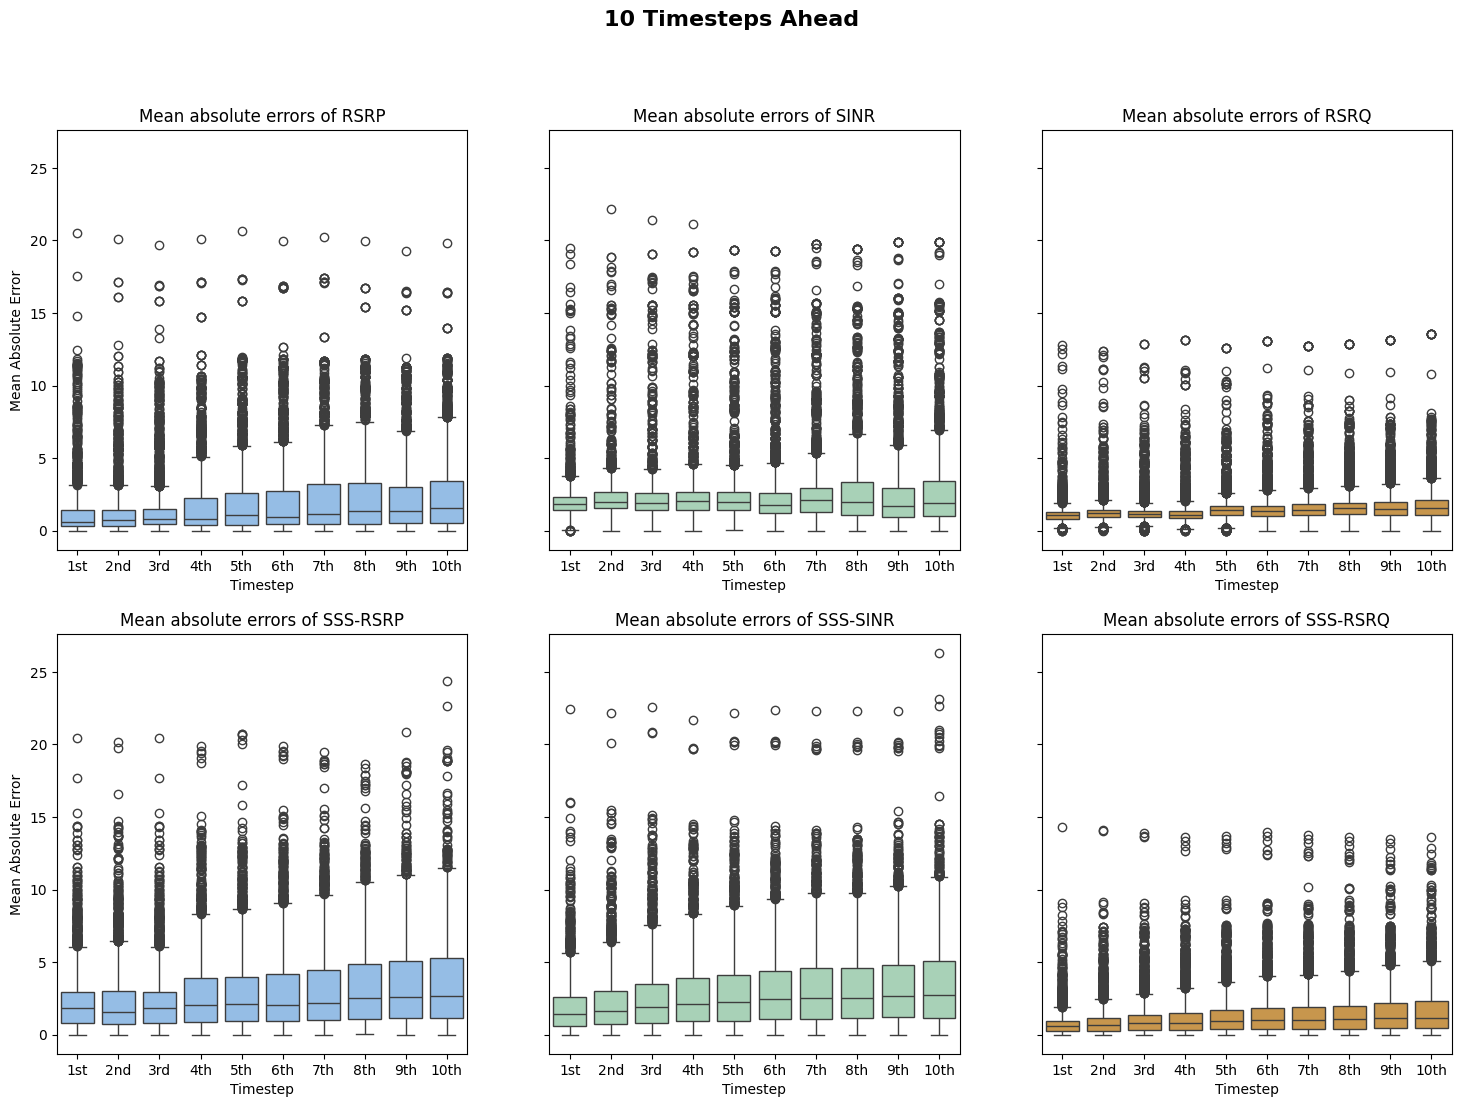

In [193]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
sns.boxplot(data=[rsrp_first_step, rsrp_second_step, rsrp_third_step, rsrp_fourth_step, rsrp_fifth_step, rsrp_6th_step, rsrp_7th_step, rsrp_8th_step, rsrp_9th_step, rsrp_10th_step], color=rsrp_colors[2], ax=axes[0, 0])
axes[0, 0].set_title('Mean absolute errors of RSRP')

sns.boxplot(data=[sinr_first_step, sinr_second_step, sinr_third_step, sinr_fourth_step, sinr_fifth_step, sinr_6th_step, sinr_7th_step, sinr_8th_step, sinr_9th_step, sinr_10th_step], color=sinr_colors[2], ax=axes[0, 1])
axes[0, 1].set_title('Mean absolute errors of SINR')

sns.boxplot(data=[rsrq_first_step, rsrq_second_step, rsrq_third_step, rsrq_fourth_step, rsrq_fifth_step, rsrq_6th_step, rsrq_7th_step, rsrq_8th_step, rsrq_9th_step, rsrq_10th_step], color=rsrq_colors[2], ax=axes[0, 2])
axes[0, 2].set_title('Mean absolute errors of RSRQ')

sns.boxplot(data=[sss_rsrp_first_step, sss_rsrp_second_step, sss_rsrp_first_step, sss_rsrp_fourth_step, sss_rsrp_fifth_step, sss_rsrp_6th_step, sss_rsrp_7th_step, sss_rsrp_8th_step, sss_rsrp_9th_step, sss_rsrp_10th_step], color=rsrp_colors[2], ax=axes[1, 0])
axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

sns.boxplot(data=[sss_sinr_first_step, sss_sinr_second_step, sss_sinr_third_step, sss_sinr_fourth_step, sss_sinr_fifth_step, sss_sinr_6th_step, sss_sinr_7th_step, sss_sinr_8th_step, sss_sinr_9th_step, sss_sinr_10th_step], color=sinr_colors[2], ax=axes[1, 1])
axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

sns.boxplot(data=[sss_rsrq_first_step, sss_rsrq_second_step, sss_rsrq_third_step, sss_rsrq_fourth_step, sss_rsrq_fifth_step, sss_rsrq_6th_step, sss_rsrq_7th_step, sss_rsrq_8th_step, sss_rsrq_9th_step, sss_rsrq_10th_step], color=rsrq_colors[2], ax=axes[1, 2])
axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

for ax in axes.flat:
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Timestep')
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'])
    
plt.suptitle(f'{n_steps_out} Timesteps Ahead', fontsize=16, fontweight='semibold')

plt.show()